데이터 준비와 확인

```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [11]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [15]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [16]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [28]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 모델 구성 RNN

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNN model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [21]:
# validation set 20000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 30000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


모델학습 시작

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=13  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/13
188/188 [==============================] - 1s 6ms/step - loss: 0.6527 - accuracy: 0.5872 - val_loss: 0.4802 - val_accuracy: 0.8019
Epoch 2/13
188/188 [==============================] - 1s 5ms/step - loss: 0.3945 - accuracy: 0.8348 - val_loss: 0.3585 - val_accuracy: 0.8452
Epoch 3/13
188/188 [==============================] - 1s 4ms/step - loss: 0.3297 - accuracy: 0.8628 - val_loss: 0.3517 - val_accuracy: 0.8465
Epoch 4/13
188/188 [==============================] - 1s 5ms/step - loss: 0.3092 - accuracy: 0.8725 - val_loss: 0.3508 - val_accuracy: 0.8480
Epoch 5/13
188/188 [==============================] - 1s 5ms/step - loss: 0.2971 - accuracy: 0.8781 - val_loss: 0.3536 - val_accuracy: 0.8471
Epoch 6/13
188/188 [==============================] - 1s 5ms/step - loss: 0.2886 - accuracy: 0.8809 - val_loss: 0.3606 - val_accuracy: 0.8468
Epoch 7/13
188/188 [==============================] - 1s 5ms/step - loss: 0.2800 - accuracy: 0.8846 - val_loss: 0.3684 - val_accuracy: 0.8453
Epoch 

모델 성능 평가

In [24]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4464 - accuracy: 0.8369
[0.4464040696620941, 0.8369306325912476]


히스토리 참고하여 그래프 그리기

In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


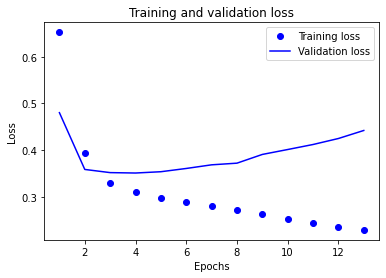

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해지게 마련입니다.

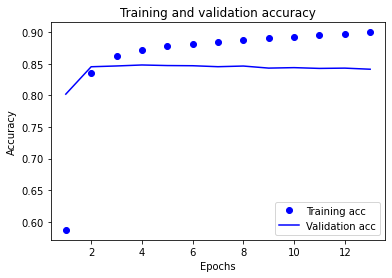

In [30]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습된 임베딩 레이어 분석

In [46]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [49]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ratings_*.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['연기']
vector

array([ 0.00412468, -0.01119531, -0.01050013, -0.00144839,  0.09201422,
        0.06494227, -0.04888293,  0.00694817,  0.01471759,  0.04172548,
       -0.02129851,  0.02507358, -0.02617178,  0.05530716, -0.0198886 ,
        0.07357518], dtype=float32)

In [51]:
word_vectors.similar_by_word("더빙")

[('??', 0.8943513631820679),
 ('병맛', 0.8360729217529297),
 ('끝', 0.8277567625045776),
 ('환불', 0.8255863785743713),
 ('지겹', 0.8250675201416016),
 ('숨바꼭질', 0.822342574596405),
 ('찍', 0.8188557624816895),
 ('공포물', 0.8184025287628174),
 ('유튜브', 0.8182110786437988),
 ('어린아이', 0.8151510953903198)]

In [52]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ratings_*.txt'

word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=100000, encoding='utf-16')
vector = word2vec['연기']
vector    

ValueError: invalid literal for int() with base 10: '㤹㘹ㄠਸ਼'

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()